# **Creating an image classifier with deep learning**

Now that we have a dataset of images of 10 different pan dulce types, we can move on to creating and training a deep learning model to classify our images. To start off, we import some of the modules that we will be using. For this project, we will use PyTorch as our deep learning framework. PyTorch was developed by a group of engineers at Meta (formerly Facebook) in 2016, and it is one of the most popular frameworks for deep learning alongside TensorFlow. To handle our image pre-processing tasks, we will use PyTorch's computer vision module, called torchvision.

In [2]:
# Import required modules
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from pan_dulce_dataset import PanDulceDataset
from skimage import io
from PIL import Image
import pandas as pd

Now, we can move on to importing our image dataset. First, we need to define some of the pre-processing steps, or transformations, that our images will go through in order to be in a model friendly form. These steps involve resizing to our desired size (224 x 224 pixels), converting the image to a PyTorch tensor, and normalizing the pixel values (Spoiler alert: we use the mean and standard deviation of the ImageNet database since it is the dataset used to train the model used for our transfer learning process). 

Once we define the transforms, we import our dataset three times for each of our dataset splits (train, test and validation) using different transformations for each split, since we will use data augmentation on our training set. Right now, they contain the same images, but in the next step we will perform the split. We also specify our classes and view the size of the dataset and how each image looks shapewise.

In [14]:
# Define transformations for images (train uses data augmentation)
means = [0.485, 0.456, 0.406]
stdvs = [0.229, 0.224, 0.225]

image_transforms = { 
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256), 
        transforms.RandomCrop(224),
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(means,
                             stdvs)
    ]),
    'test': transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(means,
                                     stdvs)])}

# Load the dataset
train_dataset = PanDulceDataset(csv_file='pan_dulce.csv',
                            root_dir='dataset',
                            transform= image_transforms['train'])

test_dataset = PanDulceDataset(csv_file='pan_dulce.csv',
                            root_dir='dataset',
                            transform= image_transforms['test'])

val_dataset = PanDulceDataset(csv_file='pan_dulce.csv',
                            root_dir='dataset',
                            transform= image_transforms['test'])

# Define the model classes
classes = ('barquillo', 'besos', 'conchita', 'cuernitos',
            'donas', 'orejas', 'pan-de-muerto',
            'puerquito', 'quequito', 'rosca-de-reyes')

# View dataset properties
print(f'Size of dataset: {len(train_dataset)}')
print(f'Image shape: {train_dataset[0][0].shape}')

Size of dataset: 1634
Image shape: torch.Size([3, 224, 224])


We have a total of 1634 images stored as tensors with shape (3, 224, 224), meaning that we have 3 channels (R, G and B) of 224 pixels each. To perform the splits, we can create a list of indices and use scikit-learn's `train_test_split` method to split our data. The reason we use this method is because it has stratified sampling integrated, meaning that if we pass a list of the labels, the algorithm will make sure that the number of classes in each split is balanced. First, we do an 80-20 split to extract our training and test set respectively, and then we split the training set into 80-20 again to extract the actual training set and the validation set. In total, we have a training set with 64% of our data, a validation set with 16% of our data and a test set with the remaining 20%. We can also see the number of images in each set.

In [4]:
# Split dataset into train, test, and validation sets
num_train = len(train_dataset)
indices = list(range(num_train))
labels = pd.read_csv('pan_dulce.csv')['label'].values

from sklearn.model_selection import train_test_split
train_indices, test_indices, train_labels, _ = train_test_split(indices, labels, test_size=0.2, stratify=labels, random_state=42)
train_indices, val_indices= train_test_split(train_indices, test_size=0.2,stratify = train_labels, random_state=42)

train_dataset = torch.utils.data.Subset(train_dataset, train_indices)
test_dataset = torch.utils.data.Subset(test_dataset, test_indices)
val_dataset = torch.utils.data.Subset(val_dataset, val_indices)

# Convert dataset to dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

print(f'Train size: {len(train_loader.dataset)}')
print(f'Validation size: {len(val_loader.dataset)}')
print(f'Test size: {len(test_loader.dataset)}')

Train size: 1045
Validation size: 262
Test size: 327


Just to make sure that the stratified sampling worked correctly, we can count the number of images of each class in each of our splits and confirm that they are roughly balanced in a 64-16-20 split. 

In [5]:
# Count number of images per class in train, validation and test
train_count = [0] * 10
val_count = [0] * 10
test_count = [0] * 10

for i in range(len(train_loader.dataset)):
    train_count[train_loader.dataset[i][1]] += 1

for i in range(len(val_loader.dataset)):
    val_count[val_loader.dataset[i][1]] += 1

for i in range(len(test_loader.dataset)):
    test_count[test_loader.dataset[i][1]] += 1

print(f'Train count: {train_count}')
print(f'Validation count: {val_count}')
print(f'Test count: {test_count}')

Train count: [45, 74, 203, 81, 76, 103, 173, 98, 79, 113]
Validation count: [11, 19, 51, 20, 19, 26, 43, 24, 20, 29]
Test count: [14, 23, 64, 25, 23, 32, 54, 31, 25, 36]


Now that we have defined our datasets, let's talk about the data augmentation process that is used in our training dataset. Data augmentation is a technique that can be used to artificially increment the size of our dataset by modifying our existing data to create new samples. It is an extremely useful tool for small datasets and a crucial part of computer vision models, since the underlying concept applies very naturally to images (a rotated or flipped image of a doughnut is still a doughnut). Since our training dataset contains only 1045 images (not a lot for a deep learning model), data augmentation will drastically improve the quality of our model. The modifications made to our training dataset are defined above in the image transforms, and in this case, we randomly flip, crop and rotate some of our images on each epoch of the training loop. Let's visualize some of these modified images.

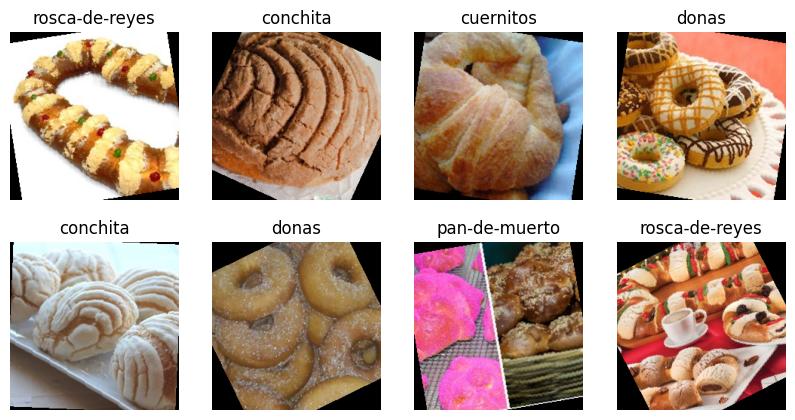

In [13]:
# View the augmented images in the training set
import matplotlib.pyplot as plt
import numpy as np

batch_X, batch_Y =  next(iter(train_loader))

plt.figure(figsize=(10, 5))
for i in range(2):
    for j in range(4):
        plt.subplot(2,4,i*4+j+1)
        img_r = batch_X[i*4+j][0] * stdvs[0] + means[0]
        img_g = batch_X[i*4+j][1] * stdvs[1] + means[1]
        img_b = batch_X[i*4+j][2] * stdvs[2] + means[2]
        img = torch.stack([img_r, img_g, img_b])
        plt.imshow(img.permute(1, 2, 0).numpy())
        plt.title(classes[batch_Y[i*4+j]])
        plt.axis('off')
plt.show()

Now, we can see some of the unmodified images located in both our test and validation sets. Since these images are used to assess model performance, they need to be in their default form and not undergo any modifications.

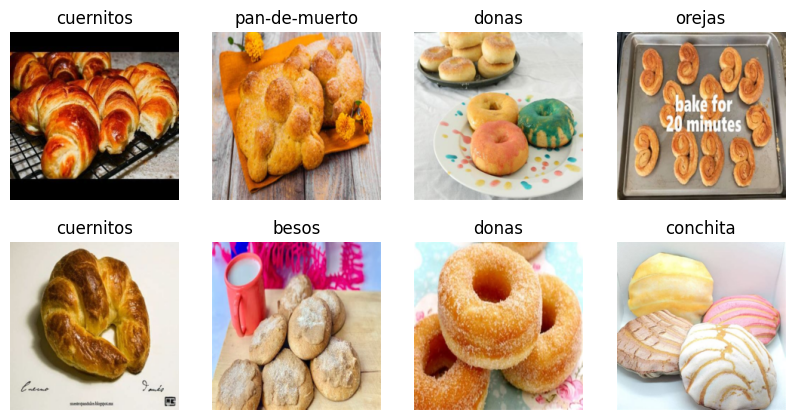

In [9]:
# View some images in the testing set
batch_X, batch_Y =  next(iter(test_loader))

plt.figure(figsize=(10,5))
for i in range(2):
    for j in range(4):
        plt.subplot(2,4,i*4+j+1)
        img_r = batch_X[i*4+j][0] * stdvs[0] + means[0]
        img_g = batch_X[i*4+j][1] * stdvs[1] + means[1]
        img_b = batch_X[i*4+j][2] * stdvs[2] + means[2]
        img = torch.stack([img_r, img_g, img_b])
        plt.imshow(img.permute(1, 2, 0).numpy())
        plt.title(classes[batch_Y[i*4+j]])
        plt.axis('off')
plt.show()

The next step is to define our deep learning model architecture. In this project, we will use a technique called transfer learning to leverage a large model for our classification task.
Transfer learning consists on loading an often large, pretrained deep learning model and re-purpose it for our particular task by adding specific components to it. It is a really popular technique to use in computer vision since a lot of these really big models are trained on huge image datasets, and their weights are already optimized for image processing tasks. The base model that will be used for our image classification task is ResNet50, developed by Kaiming He, et. al. in 2015. It contains 25,557,032 parameters and it is a very popular architecture for transfer learning in computer vision projects. We import the model with the default weights and freeze its parameters so that our training loop will not change them at all (this would make computation time extremely high and it is not needed).

In [ ]:
# Import a ResNet50 model and freeze its parameters
model = torchvision.models.resnet50(weights = 'DEFAULT')
for param in model.parameters():
    param.requires_grad = False

Now, we can substitute the last layer of the ResNet50 model, which is a classifier with 1000 labels, to our own simple neural network that will be trained specifically for pan dulce type classification with only 10 labels. Our custom neural network consists of a dense layer with a ReLU activation function, a dropout layer to prevent overfitting, and a last dense layer with 11 outputs that goes into a LogSoftmax layer for probability outputs. Our complete model has 24,562,250 parameters, where only 1,054,218 will be optimized during training. 

In [216]:
# Change the last layer of the model to our necesities
import torch.nn as nn
from torchsummary import summary

model.fc = nn.Sequential(nn.Linear(2048, 512),
                         nn.ReLU(),
                         nn.Dropout(p = 0.3),
                         nn.Linear(512, 10),                    
                         nn.LogSoftmax(dim=1))

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

Now, we define the loss function to optimize and our model optimizer. We will use cross entropy as our loss function since it the most popular loss function for multi-label classification tasks. We will also use the Adam optimizer, which is an improved version of stochastic gradient descent for optimization of deep neural networks.

In [217]:
# Define the loss function and optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Now, we define our training loop function. This training loop will loop through our training set, make predictions and obtain a loss in order to implement backpropagation to update the model weights. Then, we assess model performance on the validation dataset and save our weights if they give us the highest validation accuracy. This process is repeated for the number of epochs defined and every epoch is logged in the console with its corresponding metrics.

In [93]:
# Define training loop function
import time

def fit(model, train_loader, val_loader, criterion, optimizer, epochs=10, device='cpu'):
    start = time.time()
    print(f'Running training loop on {device}')
    history = []
    best_acc = 0.0
    for epoch in range(epochs):
        epoch_start = time.time()
        print(f'Epoch: {epoch + 1}/{epochs}')
        model.train()

        train_loss = 0.0
        train_acc = 0.0
        val_loss = 0.0
        val_acc = 0.0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            train_acc += acc.item() * inputs.size(0)
            print(f'Batch: {i+1}/{len(train_loader)}', end='\r')
        
        with torch.no_grad():
            model.eval()
            for j, (inputs, labels) in enumerate(val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                val_acc += acc.item() * inputs.size(0)
        
        avg_train_loss = train_loss/len(train_loader.dataset)
        avg_train_acc = train_acc/len(train_loader.dataset)
        avg_val_loss = val_loss/len(val_loader.dataset)
        avg_val_acc = val_acc/len(val_loader.dataset)
        history.append([avg_train_loss, avg_val_loss, avg_train_acc, avg_val_acc])
        print(f'train loss: {avg_train_loss:.4f}, train acc: {avg_train_acc:.4f}, val loss: {avg_val_loss:.4f}, val acc: {avg_val_acc:.4f}, time: {time.time() - epoch_start:.2f}s')

        if avg_val_acc >= best_acc:
            best_acc = avg_val_acc
            torch.save(model.state_dict(), 'best_checkpoint.model')
    print(f'Finished training in {time.time() - start:.2f}s. \nBest val acc: {best_acc:.4f}')
    return model, history

Now, we train our model for 15 epochs and visualize the results. PyTorch has the option of using NVIDIA's CUDA toolkit to use a GPU for training, but in this case the model was trained on a CPU, so it took a long time to finish.

In [218]:
# Train the model for 15 epochs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 15
trained_model, history = fit(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

Running training loop on cpu
Epoch: 1/15
train loss: 1.6638, train acc: 0.4919, val loss: 1.0211, val acc: 0.7939, time: 359.34s
Epoch: 2/15
train loss: 0.7854, train acc: 0.7847, val loss: 0.6298, val acc: 0.8397, time: 338.44s
Epoch: 3/15
train loss: 0.5178, train acc: 0.8507, val loss: 0.5869, val acc: 0.8282, time: 327.22s
Epoch: 4/15
train loss: 0.3814, train acc: 0.8900, val loss: 0.5084, val acc: 0.8702, time: 328.38s
Epoch: 5/15
train loss: 0.3115, train acc: 0.9129, val loss: 0.4516, val acc: 0.8817, time: 328.60s
Epoch: 6/15
train loss: 0.2571, train acc: 0.9321, val loss: 0.4616, val acc: 0.8588, time: 324.66s
Epoch: 7/15
train loss: 0.2782, train acc: 0.9139, val loss: 0.4106, val acc: 0.8893, time: 323.31s
Epoch: 8/15
train loss: 0.2045, train acc: 0.9455, val loss: 0.4447, val acc: 0.8855, time: 322.65s
Epoch: 9/15
train loss: 0.1948, train acc: 0.9502, val loss: 0.3902, val acc: 0.8931, time: 381.94s
Epoch: 10/15
train loss: 0.1800, train acc: 0.9464, val loss: 0.4266, v

From the logs, we can see that our model fluctuates at a little bit less of 90% accuracy, which is really good for a simple deep learning model trained on a low number of images. We can also see that epoch 13 had the best metrics, so further on we will load the weights of the best epoch and use those as our final weights. We can now plot the loss and accuracy of our model on each epoch and see the trend.

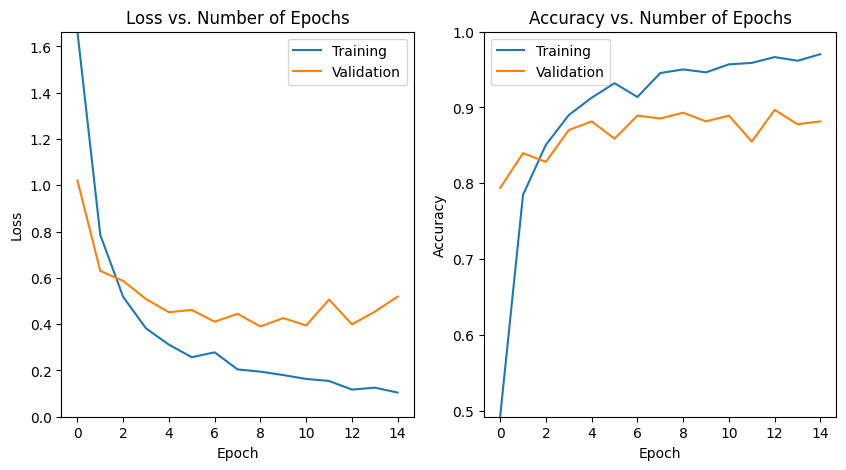

In [220]:
# Plot model performance over number of epochs
history = np.array(history)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history[:, 0:2])
plt.legend(['Training', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Number of Epochs')
plt.ylim(0, max(history[:, 0]))
plt.subplot(1, 2, 2)
plt.plot(history[:, 2:4])
plt.legend(['Training', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Epochs')
plt.ylim(min(history[:, 2]), 1)
plt.show()

The model got a lot better in the first few epochs and then it stabilized after about 10 epochs. We can also see that in the first few epochs, the model performed much better on the validation set than on the training set, and in later epochs, the training metrics were much better than the validation metrics. Now, we can load the best model weights and move on to doing a final performance assessment on the testing set.

In [225]:
# Load model checkpoint with highest validation accuracy
trained_model.load_state_dict(torch.load('best_checkpoint.model'))

<All keys matched successfully>

We will define a function that passes data through our model to make predictions and return both the predictions and the real labels.

In [227]:
# Function to make predictions
def predict(model, test_loader, device='cpu'):
    predictions = []
    real_values = []

    with torch.no_grad():
        model.eval()
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds)
            real_values.extend(labels)
            
    return predictions, real_values

Now, we test the model performance on the test set. For this, we calculate the accuracy, precision, recall, and F1 scores.

In [240]:
# Test model performance
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

predictions, real_values = predict(model, test_loader, device)
predictions = torch.stack(predictions).cpu()
real_values = torch.stack(real_values).cpu()

print(f'Accuracy: {accuracy_score(real_values, predictions):.4f} or {accuracy_score(real_values, predictions)*100:.2f}%')
print(f'Precision: {precision_score(real_values, predictions, average="weighted"):.4f} or {precision_score(real_values, predictions, average="weighted")*100:.2f}%')
print(f'Recall: {recall_score(real_values, predictions, average="weighted"):.4f} or {recall_score(real_values, predictions, average="weighted")*100:.2f}%')
print(f'F1: {f1_score(real_values, predictions, average="weighted"):.4f} or {f1_score(real_values, predictions, average="weighted")*100:.2f}%')
print('Classification report: \n', classification_report(real_values, predictions))

Accuracy: 0.8899 or 88.99%
Precision: 0.8955 or 89.55%
Recall: 0.8899 or 88.99%
F1: 0.8892 or 88.92%
Classification report: 
               precision    recall  f1-score   support

           0       0.91      0.71      0.80        14
           1       0.94      0.70      0.80        23
           2       0.89      0.91      0.90        64
           3       0.83      0.80      0.82        25
           4       0.79      0.96      0.86        23
           5       0.83      0.94      0.88        32
           6       0.85      0.94      0.89        54
           7       1.00      0.97      0.98        31
           8       1.00      0.88      0.94        25
           9       0.94      0.89      0.91        36

    accuracy                           0.89       327
   macro avg       0.90      0.87      0.88       327
weighted avg       0.90      0.89      0.89       327



We can see that our model achieves an accuracy of 88.99%, and an F1 score of 88.92% which is very good considering our project objectives. We can also visualize the confusion matrix of our test set predictions to see the actual results.

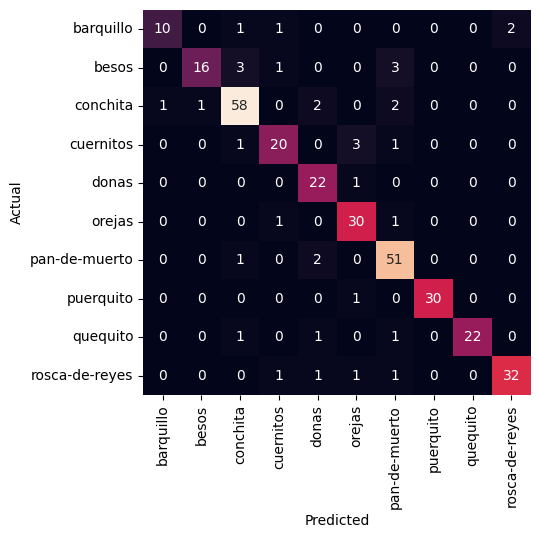

In [229]:
# Plotting the confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

predictions, real_values = predict(trained_model, test_loader, device)
cm = confusion_matrix(real_values, predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(np.arange(10) + 0.5, classes, rotation=90)
plt.yticks(np.arange(10) + 0.5, classes, rotation=0)
plt.show()

As we can see, the diagonal has a high number of samples, meaning that the accuracy of our model is pretty high. There are only a few number of misclassified examples, but if we analyze the results, we can see that it makes sense for the model to misclassify some of them. For example, some of the most common errors were images of besos classified as pan de muerto and images of cuernitos classified as orejas. If we look at these types of pan dulce, we can see that even though our human brain can correctly tell which one is which, they look pretty similar and our model made some errors in classifying some of these examples.

As a final evaluation, we will perform a sanity check by visually observing the model prediction on real, unlabeled images. These images were extracted by hand from the Facebook page of a local panaderia in Ensenada, Baja California (Panaderia Ornelas). An image from each class was taken and we will run these images through our model to see if their predictions match the actual type of pan dulce in the image. First, we import our images into a tensor format.

In [230]:
# Create dataset for real images
import os

real_dataset = torch.tensor([])

for file in os.listdir('dataset/test/'):
    img = io.imread('dataset/test/'+file)
    img = image_transforms['test'](img)
    real_dataset = torch.cat((real_dataset, img.unsqueeze(0)), 0)

Now, we pass the images through our training model and obtain the predicted probabilities and the predicted class for each of our 10 images.

In [231]:
# Predictions on real dataset
outputs = trained_model(real_dataset)
output_labels = torch.max(outputs.data, 1)
output_classes = [classes[i] for i in output_labels[1].tolist()]

Now, we plot the images with the predicted class and the probability of the image belonging to the predicted class. Probabilities close to 100% mean that the model is very sure that the image belongs to the class, while lower probabilities mean that the model had a harder time choosing a class for the image.

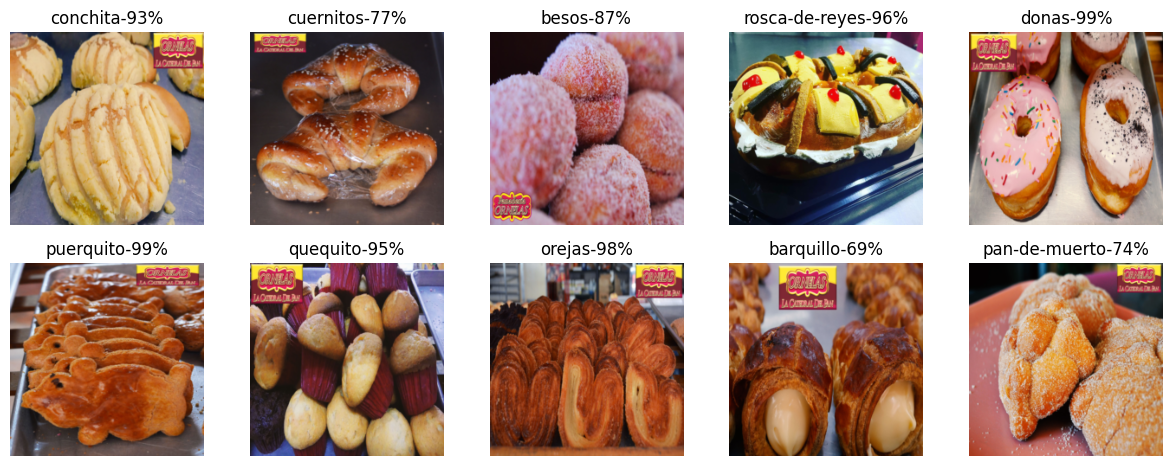

In [236]:
# Plot real predictions with probability
plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    img_r = real_dataset[i][0] * stdvs[0] + means[0]
    img_g = real_dataset[i][1] * stdvs[1] + means[1]
    img_b = real_dataset[i][2] * stdvs[2] + means[2]
    img = torch.stack([img_r, img_g, img_b])
    plt.imshow(img.permute(1, 2, 0).numpy())
    plt.title(output_classes[i] + '-' + str(int(np.exp(output_labels[0][i].item()) * 100)) + '%')
    plt.axis('off')

We can see that all of our images were correctly classified by our model, with a pretty high probability in most of them. The model had a lower probability in the barquillo, cuernitos and pan de muerto categories, but the certainty is still pretty high. Now, we save our complete trained model in order to be used by a simple web application to make predictions on user inputted images.

In [237]:
# Save trained model as .pt file
torch.save(trained_model, 'pan_dulce_model.pt')

With our model saved, we can now open it on our web app and use it to make predictions on new images. In the final step of the project, we will design and develop this web application using the `Streamlit` platform.